In [1]:
from datasets import load_dataset

dataset = load_dataset("banking77")

Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

Dataset banking77 downloaded and prepared to /root/.cache/huggingface/datasets/banking77/default/1.1.0/aec0289529599d4572d76ab00c8944cb84f88410ad0c9e7da26189d31f62a55b. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

In [6]:
# X_train = pd.DataFrame(dataset["train"]["text"], columns=["text"])
y_train = pd.DataFrame(dataset["train"]["label"], columns=["label"])

# X_test = pd.DataFrame(dataset["test"]["text"], columns=["text"])
y_test = pd.DataFrame(dataset["test"]["label"], columns=["label"])

In [4]:
%%capture
!pip install nltk
!pip install contractions
!pip install Unidecode
!pip install textblob
!pip install pyspellchecker

In [262]:
import contractions
import re
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from string import punctuation
from textblob import TextBlob
from unidecode import unidecode


class EnglishPipeline():
    
    def __init__(self,
                 uncased=False,
                 lemmatized=False,
                 stemmed=False,
                 remove_stopwords=False,
                 remove_contractions=False,
                 remove_numbers=False,
                 remove_punctuation=False,
                 fix_spelling=False
                ):
    
        self.uncased = uncased
        self.lemmatized = lemmatized
        self.stemmed = stemmed
        self.remove_stopwords = remove_stopwords
        self.remove_contractions = remove_contractions
        self.remove_numbers = remove_numbers
        self.remove_punctuation = remove_punctuation
        self.fix_spelling = fix_spelling

        if self.remove_stopwords:
            nltk.download("stopwords")
            self.stopwords = stopwords.words('english')
        if self.stemmed:
            if self.lemmatized:
                self.lemmatized = False
            self.stemmer = SnowballStemmer("english")
        if self.lemmatized:
            self.nlp = spacy.load("en_core_web_sm")
    
    def transform(self, string):
        
        if self.uncased:
            string = string.lower()
            
        # remove diacritics
        string = unidecode(string, errors="preserve")
            
        if self.remove_contractions:
            string = " ".join([contractions.fix(expanded) for expanded in string.split()])
            
        if self.remove_numbers:
            string = re.sub(r'\d+', '', string)
            
        if self.fix_spelling:
            string = str(TextBlob(string).correct())
            
        if self.remove_punctuation:
            string = " ".join(x for x in word_tokenize(string) if x not in punctuation)
            
        if self.lemmatized:
            string = " ".join(x.lemma_ for x in self.nlp(string))
        elif self.stemmed:
            string = self.stemmer.stem(string) 
            
        if self.remove_stopwords:
            string = " ".join([word for word in string.split() if word not in self.stopwords])
            
        # remove trailing spaces
        string = re.sub(' +', ' ', string)
        
        return string

In [6]:
pipeline = EnglishPipeline(uncased=False,
                           lemmatized=True,
                           stemmed=False,
                           remove_stopwords=False,
                           remove_contractions=True,
                           remove_numbers=True,
                           remove_punctuation=False,
                           fix_spelling=True)

In [9]:
from tqdm.auto import tqdm
tqdm.pandas()

with open("/kaggle/input/some-stuff/intent_mapper.txt", "r") as f:
    intent_mapper = {int(x.split()[0]): x.split()[1] for x in f.readlines()}

X_train["lemmas"] = X_train["text"].progress_apply(lambda x: pipeline.transform(x))
X_test["lemmas"] = X_test["text"].progress_apply(lambda x: pipeline.transform(x))
y_train["label"] = y_train["label"].map(intent_mapper)
y_test["label"] = y_test["label"].map(intent_mapper)

  0%|          | 0/10003 [00:00<?, ?it/s]

  0%|          | 0/3080 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Train Labels distribution')

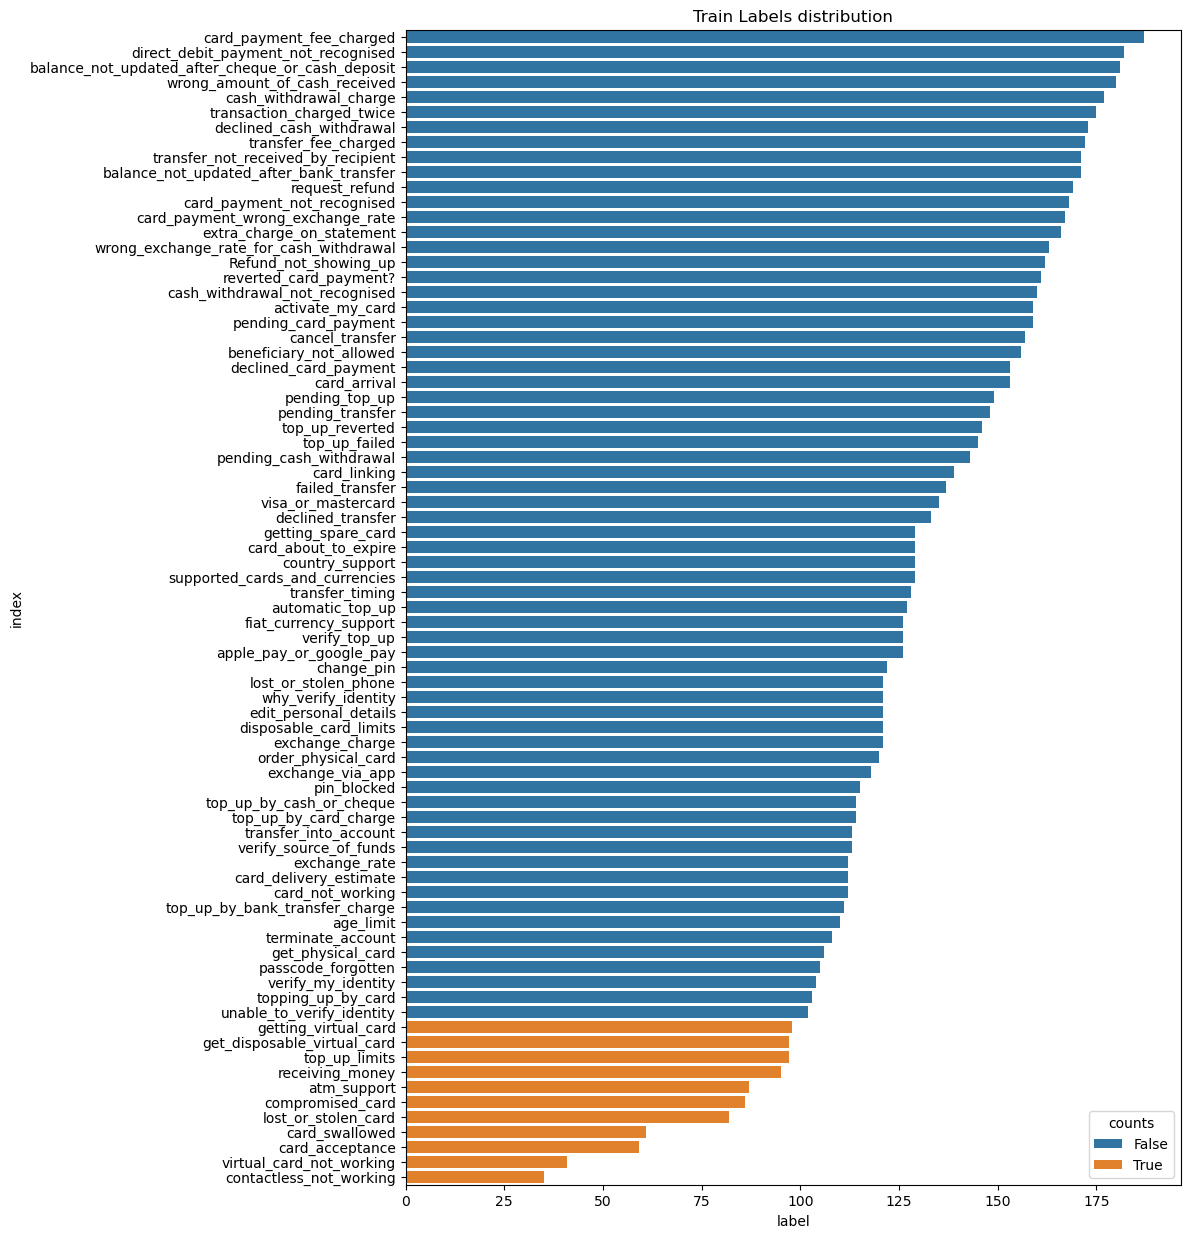

In [11]:
sub_df = y_train['label'].value_counts().reset_index()
sub_df["counts"] = sub_df.label < 100

plt.figure(figsize=(10, 15))
sns.barplot(y="index", x="label", hue="counts", data=sub_df, dodge=False)
plt.title("Train Labels distribution")

# y_train.value_counts().plot.bar()

То, что оранжевым - явно несбалансированно. Можно доаугментить данных, можно не трогать, можно взять планку повыше и доаугментить более частые категории. В целом всё довольно балансно

Text(0.5, 1.0, 'Test Labels distribution')

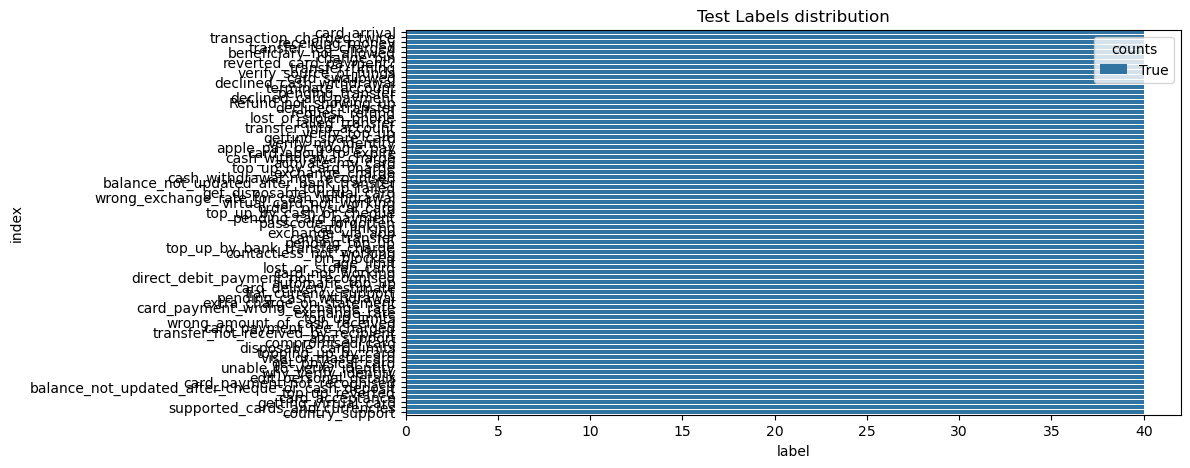

In [12]:
sub_df = y_test['label'].value_counts().reset_index()
sub_df["counts"] = sub_df.label < 100


plt.figure(figsize=(10, 5))
sns.barplot(y="index", x="label", hue="counts", data=sub_df, dodge=False)
plt.title("Test Labels distribution")

# y_train.value_counts().plot.bar()

На тесте всё ровно, это и хорошо - можно проверить все лейблы, и плохо - в жизни распределение не такое

In [17]:
X_train["sent_len"] = X_train.text.apply(lambda x: len(x.split()))
X_test["sent_len"] = X_test.text.apply(lambda x: len(x.split()))

Text(0.5, 0.98, 'Sentence length distribution')

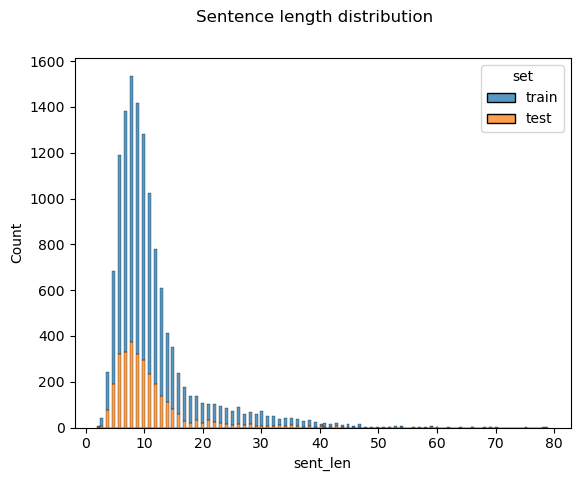

In [18]:
sub_df = pd.concat([X_train, X_test])

sns.histplot(x="sent_len", data=sub_df, hue="set", multiple="stack")
plt.suptitle("Sentence length distribution")

В среднем очень короткие тексты - по 10 слов, максимум 40-52

In [20]:
X_train["punct_count"] = X_train.text.apply(lambda x: len("".join(_ for _ in x if _ in punctuation))) 
X_test["punct_count"] = X_test.text.apply(lambda x: len("".join(_ for _ in x if _ in punctuation)))

X_train["set"] = "train"
X_test["set"] = "test"

Text(0.5, 0.98, 'Punctuation count distribution')

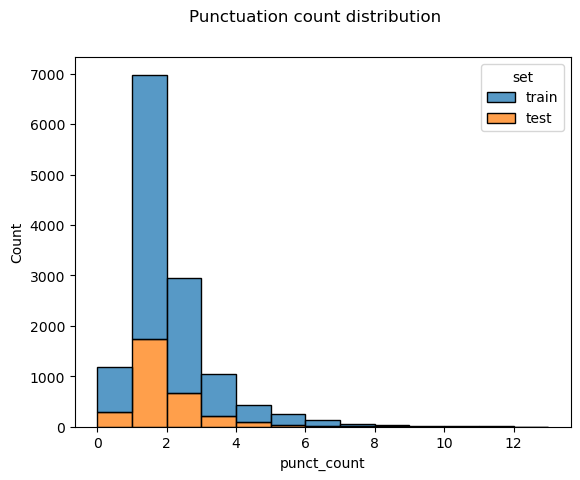

In [21]:
sub_df = pd.concat([X_train, X_test])

sns.histplot(x="punct_count", data=sub_df, hue="set", multiple="stack", binwidth=1)
plt.suptitle("Punctuation count distribution")

По пунктуации вроде ничего особо сказать нельзя. 1. Слишком короткие предложения. 2. Обычно пунктуация ограничивается точкой или вопросительным знаком. Я бы выкинул, там есть исключения, но вряд ли они влияют на интент

Text(0.5, 0.98, 'Punctuation count with respect to sentence length')

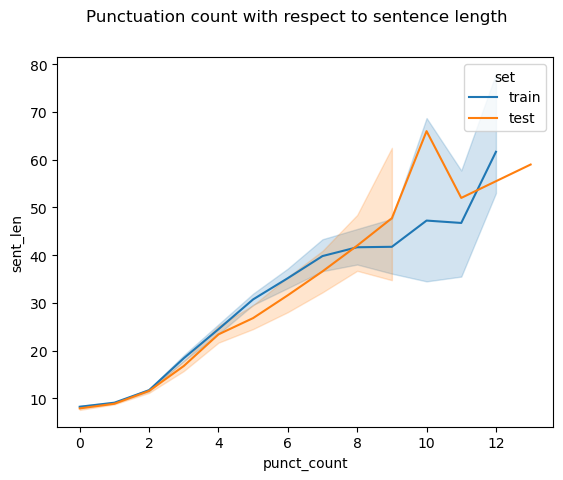

In [22]:
sub_df = pd.concat([X_train, X_test])

sns.lineplot(x="punct_count", y="sent_len", data=sub_df, hue="set")
plt.suptitle("Punctuation count with respect to sentence length")

In [23]:
sample = X_train[X_train["punct_count"] > 6].text.sample(5).index
X_train[X_train["punct_count"] > 6].shape[0]

90

Таких предложений очень мало, имеет смысл попробовать в ood

In [24]:
X_train.iloc[sample]["text"].values

array(["My money is gone :( I had topped up recently and saw it was there and went through, but now it's disappeared, what's going on?",
       'I NEED HELP WITH MY CARD!!!!! please. It keeps getting declined when I try to use it. I have tried a few times to use it and it keeps getting rejected. I have no idea why.',
       "|I moved out of my old house two weeks ago and cancelled my direct debit to my old landlord, this direct debit was working fine.  Now I've moved in to a new place and set up a transfer to a new landlord but it's not reached her yet, can you check it please?",
       "What did you do with my money??? I just topped up, I saw the money was there, but now it's gone!! What did you do with it?",
       "I'm stuck here at your broken ATM and I don't know what to do next. Asked for 30 pounds, got 10. ATM said I got 30. Something very wrong here and I want my money now!"],
      dtype=object)

Но лейблы там совсем разные, вряд ли поможет их предсказывать, хотя определённые топики тут всплывают чаще

Text(0.5, 1.0, 'Punctuation-label distribution')

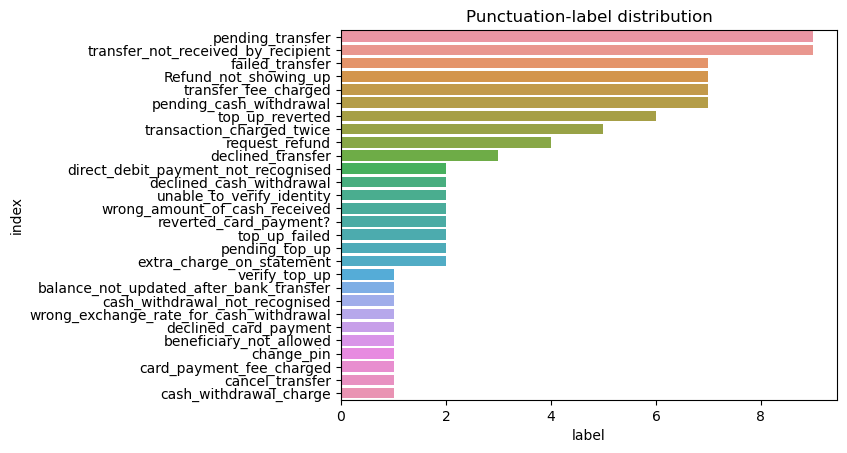

In [25]:
sub_df = y_train[X_train["punct_count"] > 6]['label'].value_counts().reset_index()

sns.barplot(y="index", x="label", data=sub_df, dodge=False)
plt.title("Punctuation-label distribution")

In [26]:
pipeline = EnglishPipeline(lemmatized=False, remove_punctuation=True)
X_train["lemmas"] = X_train["lemmas"].progress_apply(lambda x: pipeline.transform(x))
X_test["lemmas"] = X_test["lemmas"].progress_apply(lambda x: pipeline.transform(x))

  0%|          | 0/10003 [00:00<?, ?it/s]

  0%|          | 0/3080 [00:00<?, ?it/s]

In [27]:
X_train["char_count"] = X_train.text.apply(len)
X_test["char_count"] = X_test.text.apply(len)

Text(0.5, 0.98, 'Character count distribution')

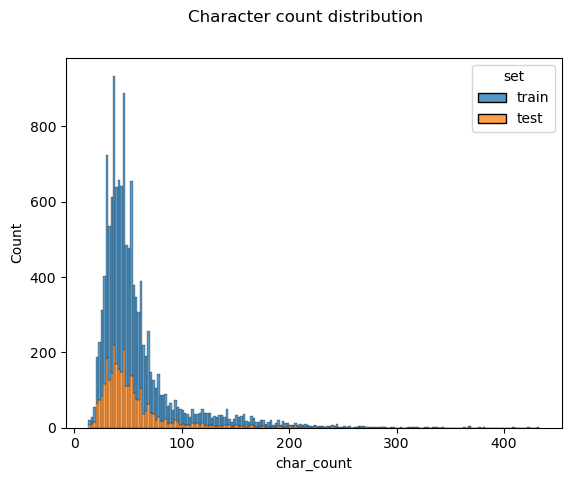

In [28]:
sub_df = pd.concat([X_train, X_test])

sns.histplot(x="char_count", data=sub_df, hue="set", multiple="stack")
plt.suptitle("Character count distribution")

Распределение длин символов почти такое же, как длин предложений, лишняя фича скорее всего

In [29]:
X_train["text_density"] = X_train['char_count'] / (X_train['sent_len']+1)
X_test["text_density"] = X_test['char_count'] / (X_test['sent_len']+1)

Text(0.5, 0.98, 'Average word length distribution')

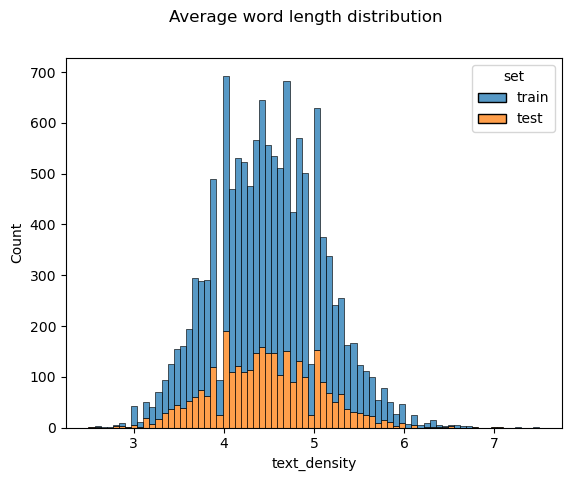

In [30]:
sub_df = pd.concat([X_train, X_test])

sns.histplot(x="text_density", data=sub_df, hue="set", multiple="stack")
plt.suptitle("Average word length distribution")

Обычно слова довольно короткие - 4-5 символов, можно искать ood в чём-то длинном

In [59]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 1))
cv_data = vectorizer.fit_transform(X_train.lemmas)

cv_data

<10003x1697 sparse matrix of type '<class 'numpy.int64'>'
	with 101636 stored elements in Compressed Sparse Row format>

Уникальных слов вообще очень мало - 2320, лемм - 1697, видимо, не стоит выкидывать стопслова, и так очень мало, может быть, лемматизировать тоже не стоит, а вот привести к нижнему регистру - наоборот

(-0.5, 1599.5, 799.5, -0.5)

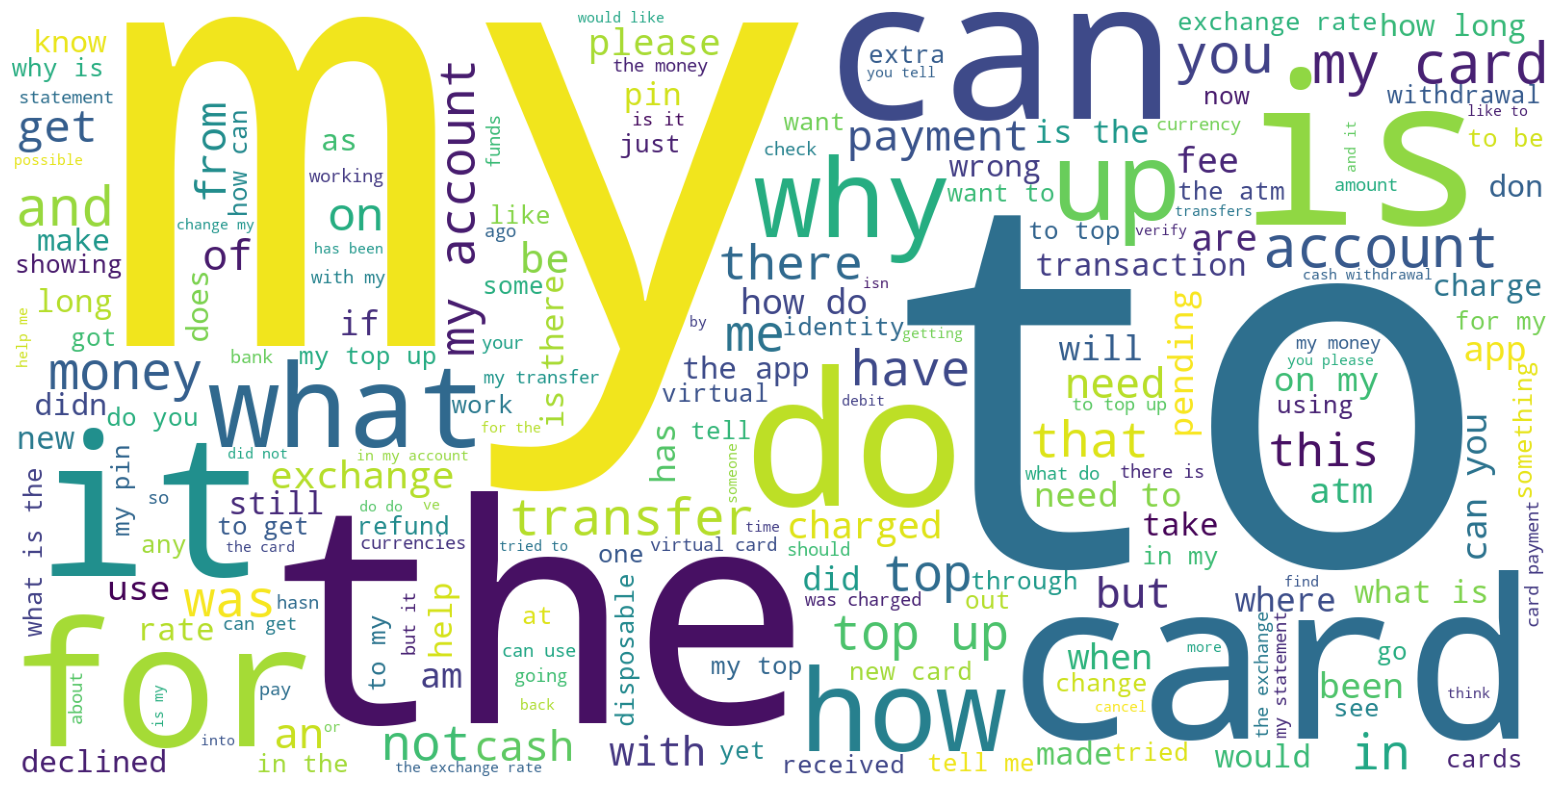

In [60]:
from wordcloud import WordCloud

vectorizer = CountVectorizer(ngram_range=(1, 5))
cv_data = vectorizer.fit_transform(X_train.text)
sum_words = cv_data.sum(axis=0)
    
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

wordcloud = WordCloud(background_color="white",
                      width=1600, height=800).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")

Большинство нграмм так или иначе связано с банками, что логично, но это подсказывает нам, где брать ood-примеры - явно не с этими словами

In [176]:
blob = TextBlob(str(X_train.text))
pos_df = pd.DataFrame(blob.tags, columns=['word', 'pos'])
#top_pos = pd.DataFrame(pos_df['pos'].value_counts(), columns=['pos', 'count'])
top_pos = pos_df['pos'].value_counts()

In [31]:
from collections import Counter
from nltk import pos_tag

def get_pos(df):
    
    pos = []
    
    for i in tqdm(range(df.shape[0])):
        
        poss = Counter()
        blob = pos_tag(df.iloc[i].lemmas.split(), tagset='universal')

        for word, tag in blob:
            if tag in poss:
                poss[tag] += 1
            else:
                poss.update({tag: 0})
        
        pos.append(poss)
        
    return pd.DataFrame(pos).fillna(0.0)

In [32]:
train_pos = get_pos(X_train)
test_pos = get_pos(X_test)

  0%|          | 0/10003 [00:00<?, ?it/s]

  0%|          | 0/3080 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Parts of speech distribution')

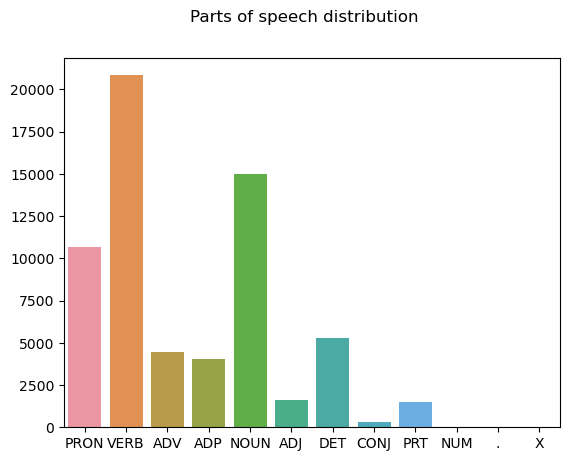

In [36]:
sub_df = train_pos.sum()
sns.barplot(x=sub_df.index, y=sub_df.values)
plt.suptitle("Parts of speech distribution")

Это не очень интересная информация, но это +фичи, вряд ли сильно помогут, но потенциал есть

In [39]:
nltk.download("stopwords")
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
X_train['sw_count'] = X_train['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stopwords]))
X_test['sw_count'] = X_test['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stopwords]))

Text(0.5, 0.98, 'Stopword count distribution')

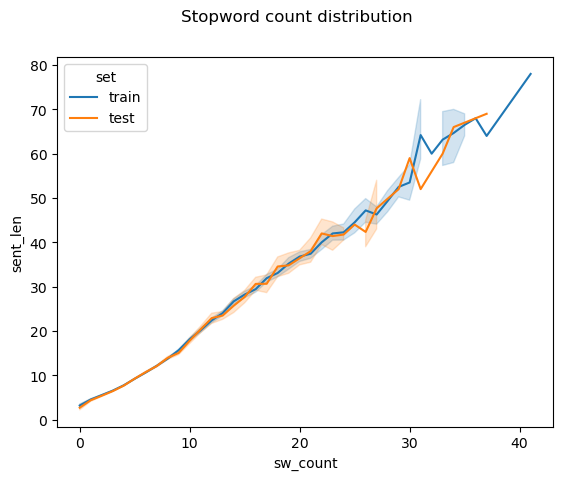

In [41]:
sub_df = pd.concat([X_train, X_test])

sns.lineplot(x="sw_count", y="sent_len", data=sub_df, hue="set")
plt.suptitle("Stopword count distribution")

Число стопслов коррелирует с длиной предложения, просто по их наличию что-то сказать сложно, но в составе нграмм могут быть полезны

In [42]:
X_train['cased_count'] = X_train['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
X_test['cased_count'] = X_test['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

Text(0.5, 0.98, 'Stopword count distribution')

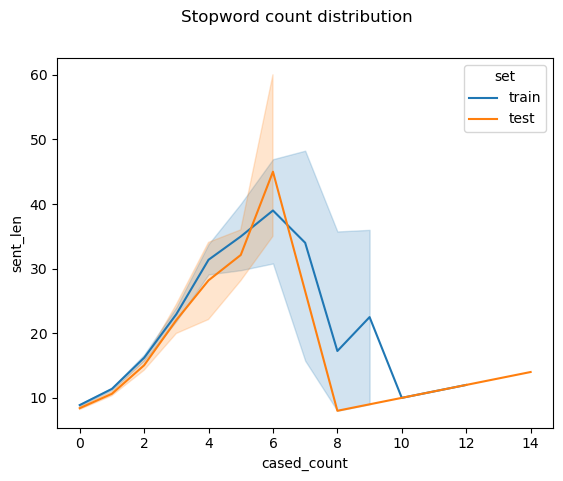

In [43]:
sub_df = pd.concat([X_train, X_test])

sns.lineplot(x="cased_count", y="sent_len", data=sub_df, hue="set")
plt.suptitle("Stopword count distribution")

In [87]:
X_train[X_train["cased_count"] > 6].text.values

array(['I NEED HELP WITH MY CARD!!!!! please. It keeps getting declined when I try to use it. I have tried a few times to use it and it keeps getting rejected. I have no idea why.',
       'HOW DO I TRANSFER MONEY FROM MY BANK ACCOUNT?',
       'I AM MISSING CASH FROM MY BANK ACCOUNT ACCORDING TO MY APP',
       'WHY IS THERE AN EXTRA FEE FOR USING THE ATM??!!!'], dtype=object)

Text(0.5, 1.0, 'Punctuation-label distribution')

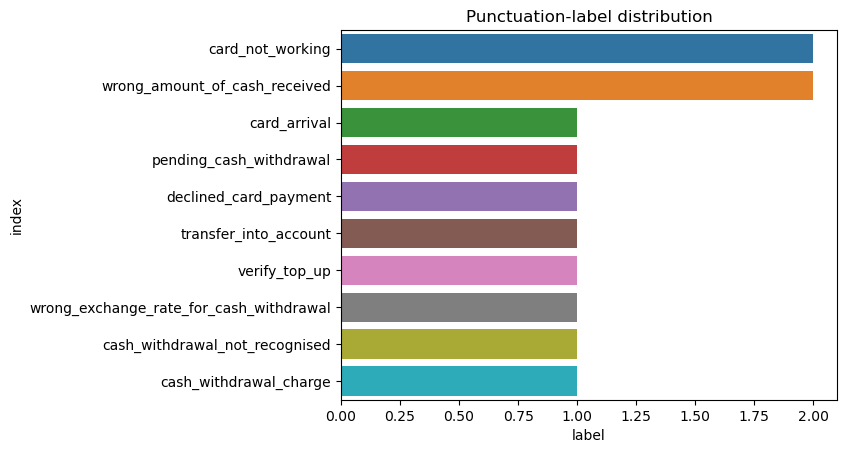

In [133]:
sub_df = y_train[X_train["cased_count"] > 6]['label'].value_counts().reset_index()

sns.barplot(y="index", x="label", data=sub_df, dodge=False)
plt.title("Punctuation-label distribution")

Обычно капса много там, где что-то свзяанное с картами, оплатами и обналичиванием, вроде бы даже не особо пересекается с пунктуационными лейблами

Ещё можно попробовать посчитать сентимент и субъективность. Это обычно полезно во всяких отзывах, ну а вдруг. Если будет норм, можно будет взять хорошую модель под это дело

In [44]:
def get_polarity(text):

    textblob = TextBlob(text)
    pol = textblob.sentiment.polarity

    return pol

X_train['polarity'] = X_train['text'].apply(get_polarity)
X_test['polarity'] = X_test['text'].apply(get_polarity)

Text(0.5, 0.98, 'Text polarity')

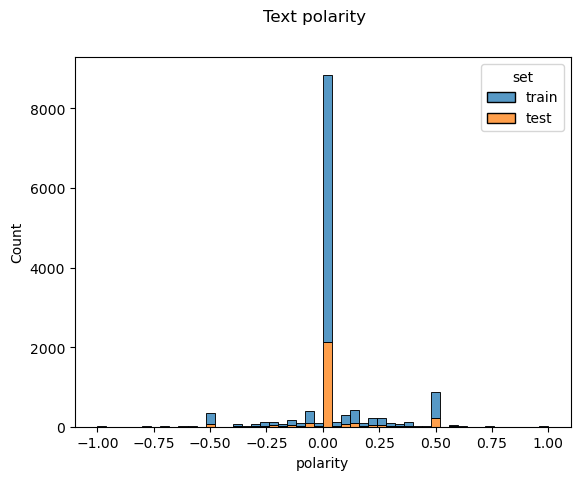

In [45]:
sub_df = pd.concat([X_train, X_test])

sns.histplot(x="polarity", data=sub_df, hue="set", multiple="stack", bins=50)
plt.suptitle("Text polarity")

In [153]:
X_test[X_test["polarity"] < -0.6].text.values

array(['What is the base of the exchange rates?',
       'What do you base your exchange rates on?',
       'Some idiot stole my card.',
       "I need you to cancel a transfer that I made.  It is the wrong account number and the app won't let me stop the transaction.  Please stop it!",
       'It is impossible to verify my identity',
       'Someone stole my phone yesterday :( is there anything I need to do?',
       'This company is terrible! Can you delete my account?',
       'This company is bad, please delete my account.',
       'I am sick of this damn company and want to close out my account.',
       'Your service is terrible,.  Delete my account,',
       'Tell me why my transfer failed!',
       'I took out money from a transaction machine and it exchanged the wrong dollar value amount from another currency!',
       'I used the ATM machine to get money out for Holiday shopping and saw the outrageous charges. Why is that? I would not have used the ATM if I had known!',
     

Ну вообще иногда работает, но большинство просто нейтральные, скорее всего, потому что слишком маленькие. Можно покопаться, но хз, будет это полезно или нет

Text(0.5, 1.0, 'Punctuation-label distribution')

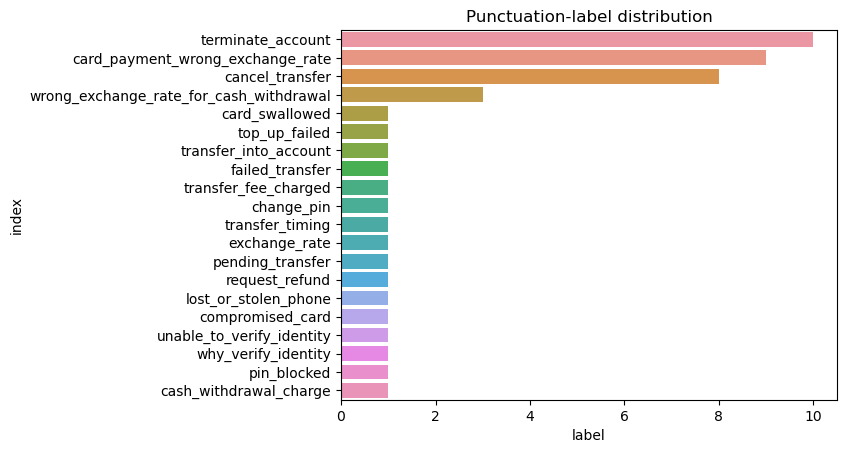

In [175]:
sub_df = y_train[X_train["polarity"] < -0.5]['label'].value_counts().reset_index()

sns.barplot(y="index", x="label", data=sub_df, dodge=False)
plt.title("Punctuation-label distribution")

Text(0.5, 1.0, 'Punctuation-label distribution')

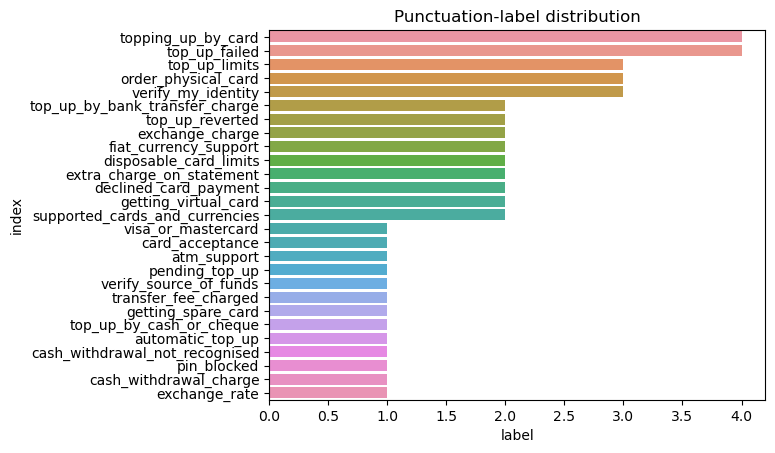

In [176]:
sub_df = y_train[X_train["polarity"] > 0.5]['label'].value_counts().reset_index()

sns.barplot(y="index", x="label", data=sub_df, dodge=False)
plt.title("Punctuation-label distribution")

Хотя какие-то лейблы, типа закрытия аккаунта прям чётко ассоциируются с негативностью. С позитивной полярностью всё не так хорошо

Дальше я пока пытаюсь найти какую-нибудь закономерность в данных, чтобы их покластеризовать, пока безрезультатно

In [46]:
def make_svd_right(svd, n):
    
    u, s, vt = svd

    u[:,:n] = u[:, n-1::-1]
    s = s[::-1]
    vt[:n, :] = vt[n-1::-1, :]

    vt = vt.T
    
    return u, s, vt

In [111]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 5))
tfidf_vectorizer.fit(X_train.text)
tfidf_data = tfidf_vectorizer.transform(X_test.text)

Можно посмотреть на распределение запросов в пространстве, но кластеров слишком много, вряд ли сможем увидеть их все

In [112]:
from sklearn.manifold import TSNE

tsne = TSNE(2)
proj = tsne.fit_transform(tfidf_data)

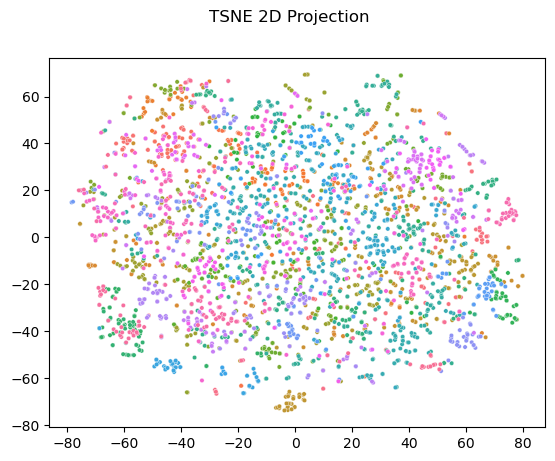

In [117]:
sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=y_test["label"], s=10)
plt.suptitle("TSNE 2D Projection")
plt.legend([],[], frameon=False)

На самом деле видно, что некоторые кластеры хорошо выделяются даже через tfidf, но большинство всё-таки лежат слишком плотно

In [125]:
import scipy

u, s, vt = make_svd_right(scipy.sparse.linalg.svds(tfidf_data, 3), 3)

Сингулярные значения довольно маленькие по модулю и не то чтобы быстро убывают, чтобы сделать нормальный LSA придётся взять большую размерность => PCA не сработает

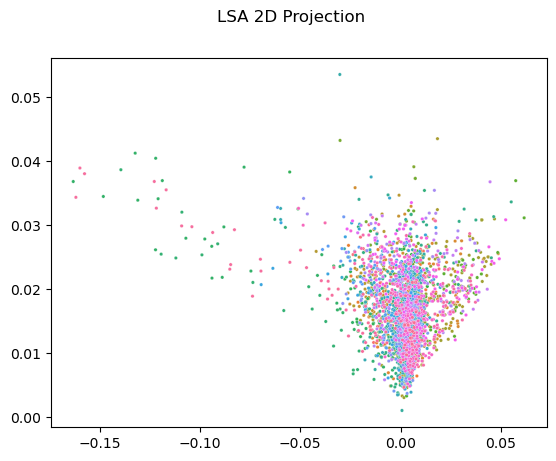

In [129]:
sns.scatterplot(y=u[:, 0], x=u[:, 1], hue=y_test["label"], s=6)
plt.suptitle("LSA 2D Projection")
plt.legend([],[], frameon=False)

In [130]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(2, 5), analyzer="char")
tfidf_data = tfidf_vectorizer.fit_transform(X_train.text)

In [ ]:
from sentence_transformers import SentenceTransformer

sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [132]:
from sklearn.manifold import TSNE

tsne = TSNE(2)
proj = tsne.fit_transform(tfidf_data)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


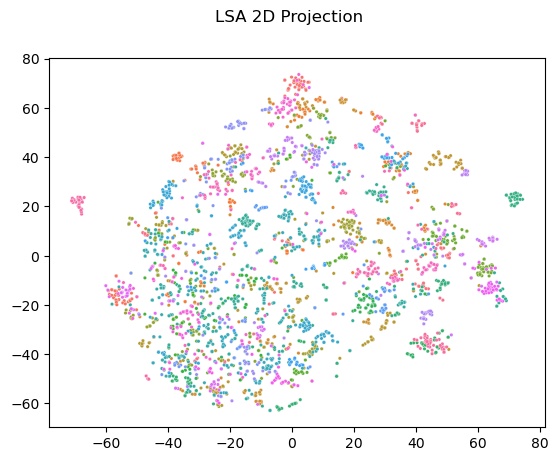

In [180]:
sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=y_test["label"], s=6)
plt.suptitle("LSA 2D Projection")
plt.legend([],[], frameon=False)

С символами гораздо лучше, но всё равно плохо

In [ ]:
!pip instal%%capture
!pip install sentence_transformers

In [ ]:
%%capture
from sentence_transformers import SentenceTransformer

sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [167]:
sentence_embeddings = sbert_model.encode("Hi, my name is Billy")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [242]:
sentence_embeddings = sbert_model.encode(X_test.append({"text": "The main reason behind terrorist attacks is"}, ignore_index=True).text)

Batches:   0%|          | 0/97 [00:00<?, ?it/s]

In [243]:
tsne = TSNE(2, random_state=777)
proj = tsne.fit_transform(sentence_embeddings)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


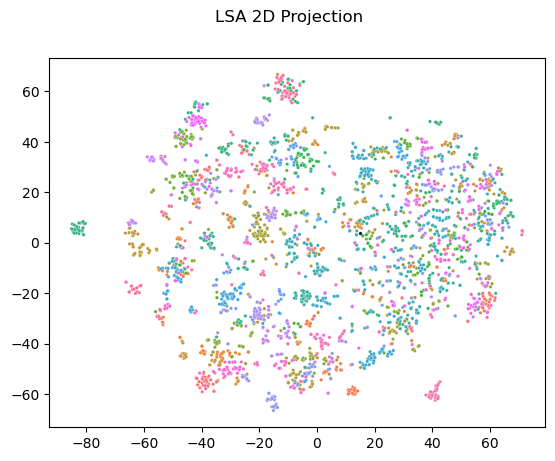

In [244]:
sns.scatterplot(x=proj[:-1, 0], y=proj[:-1, 1], hue=y_test["label"], s=6)
sns.scatterplot(x=[proj[-1, 0]], y=[proj[-1, 1]], color="black", s=6)

plt.suptitle("LSA 2D Projection")
plt.legend([],[], frameon=False)

In [245]:
ood = sentence_embeddings[-1]

In [246]:
from sklearn.metrics.pairwise import cosine_similarity

print(np.max(cosine_similarity([ood], sentence_embeddings[:-1])))
idx = np.argmax(cosine_similarity([ood], sentence_embeddings[:-1]))
print(y_test.iloc[idx])
X_test.iloc[idx]

0.62432176
card_payment_not_recognised


text             I think my statement has a fraudulent charge
lemmas          I think my statement have a fraudulent charge
punct_count                                                 0
set                                                      test
sent_len                                                    8
char_count                                                 44
text_density                                         4.888889
sw_count                                                    4
cased_count                                                 1
polarity                                                  0.0
Name: 1101, dtype: object

Через эмбеддинги из берта получается гораздо лучше, но всё равно слишком плохо, чтобы пытаться найти здесь дополнительные фичи